It is sometimes usefull to be able to convert a decision tree into and actual usefull code snippet. This notebook shows how you'd go around to achieve this.

We will use as an example, the iris dataset (which is a toy example and not really that interesting but sufficiently interesting that we can show a usable final result and make a point).

We will take the dataset, split it into training set and testing set (70%/15%) and we will train a minimal DecisionTree over it.

With the above trained decision tree we can convert it into actual python code.

# Setup

In [6]:
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

Get the dataset

In [2]:
dataset = load_iris()
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Train / test splitting.

In [23]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
df_train.shape, df_test.shape, df_train.shape[0] / (df_train.shape[0] + df_test.shape[0])

((105, 5), (45, 5), 0.7)

Train the `DecisionTree` model that we will work on.

In [24]:
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(df_train.drop(columns='target'), df_train['target'])

print(classification_report(df_test['target'], dt.predict(df_test.drop(columns='target'))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



The tree we've just trained[*] has the structure from the figure bellow.

[*] We've used the [dtreeviz](https://github.com/parrt/dtreeviz) library to generate this visualisation and since we have a fixed `random_state=0` in all steps that might generate different results between runs, I'm pretty confident that this outcome is reproducible.  

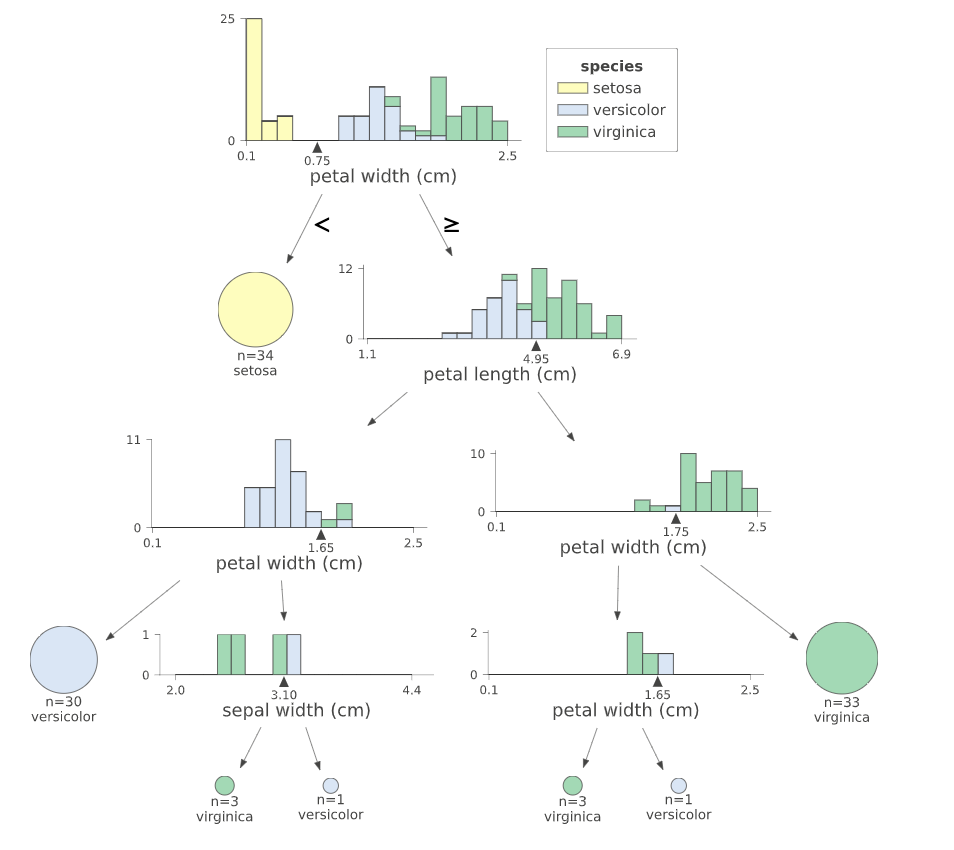

# Code conversion

Ok, so we have a `DecisionTree` object that functions as you can see above and we want to convert that into actual running code. 

We will largely use and improve upon the code @paulkernfeld and @NirIzr provided in [this stackoverflow answer](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree).

In [25]:
from sklearn.tree import _tree
PYTHON_INDENT_STEP = "  "

def pythonize(feature_name):
    """
    Since we will be likely using the columns names of some datasets, and will wish to 
    have some python parmeters for referencing them we need to make sure that these 
    names abide by the python varible nameing convention.

    This function is a really quick and dirty way of achieveing this, in through some quick replace rules.
    """
    return (
        feature_name
            .replace(" ", "_")
            .replace("(", "_")
            .replace(")", "_")
            .replace("__", "_")
    )

def get_node_feature_names(tree_, feature_names):
    """
    Whenever possible, return the feature names (as in strings)
    """
    try:
        return [
            pythonize(feature_names[i]) if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]
    except:
        # when something goes wrong with the above, we will have numbers in the `tree_.feature` list 
        # which we want to convert to actual python variable names (i.e. by converting 5 to "_5")

        # TODO: maybe add this rule to the `pythonize` function and use here instead
        return [f"_{i}" for i in tree_.feature]
    
def stringify_list(_list):
    return f"[{', '.join(str(i) for i in _list)}]"

def probabilities(node_counts):
    """
    By default, the tree stores the number of datapoints from each class in a leaf node (as the node values)
    but we want to convert this into probabilities so the generated code acts like a propper model.

    We can use `softmax` of other squish-list-to-probabilities formulas (in this case `a / sum(A)`)
    """
    return node_counts / np.sum(node_counts)

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_names = list(map(pythonize, feature_names))
    node_feature_name = get_node_feature_names(tree_, feature_names)
    print(f"def tree_model({', '.join(feature_names)}):")

    def __recurse(node, depth):
        indent = PYTHON_INDENT_STEP * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = node_feature_name[node]
            threshold = tree_.threshold[node]
            
            print(f"{indent}if ({name} <= {threshold}):")
            __recurse(tree_.children_left[node], depth + 1)

            print(f"{indent}else:  # if ({name} > {threshold})")
            __recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return {stringify_list(probabilities(tree_.value[node][0]))}")

    __recurse(0, 1)

tree_to_code(dt, df.columns)

def tree_model(sepal_length_cm_, sepal_width_cm_, petal_length_cm_, petal_width_cm_, target):
  if (petal_width_cm_ <= 0.75):
    return [1.0, 0.0, 0.0]
  else:  # if (petal_width_cm_ > 0.75)
    if (petal_length_cm_ <= 4.950000047683716):
      if (petal_width_cm_ <= 1.6500000357627869):
        return [0.0, 1.0, 0.0]
      else:  # if (petal_width_cm_ > 1.6500000357627869)
        if (sepal_width_cm_ <= 3.100000023841858):
          return [0.0, 0.0, 1.0]
        else:  # if (sepal_width_cm_ > 3.100000023841858)
          return [0.0, 1.0, 0.0]
    else:  # if (petal_length_cm_ > 4.950000047683716)
      if (petal_width_cm_ <= 1.75):
        if (petal_width_cm_ <= 1.6500000357627869):
          return [0.0, 0.0, 1.0]
        else:  # if (petal_width_cm_ > 1.6500000357627869)
          return [0.0, 1.0, 0.0]
      else:  # if (petal_width_cm_ > 1.75)
        return [0.0, 0.0, 1.0]


Let's also store this code into a python file that we can later on load and use.

In [26]:
import io
from contextlib import redirect_stdout

with open("python_code_model.py", "w") as buf, redirect_stdout(buf):
    tree_to_code(dt, df.drop(columns='target').columns)

!cat python_code_model.py

def tree_model(sepal_length_cm_, sepal_width_cm_, petal_length_cm_, petal_width_cm_):
  if (petal_width_cm_ <= 0.75):
    return [1.0, 0.0, 0.0]
  else:  # if (petal_width_cm_ > 0.75)
    if (petal_length_cm_ <= 4.950000047683716):
      if (petal_width_cm_ <= 1.6500000357627869):
        return [0.0, 1.0, 0.0]
      else:  # if (petal_width_cm_ > 1.6500000357627869)
        if (sepal_width_cm_ <= 3.100000023841858):
          return [0.0, 0.0, 1.0]
        else:  # if (sepal_width_cm_ > 3.100000023841858)
          return [0.0, 1.0, 0.0]
    else:  # if (petal_length_cm_ > 4.950000047683716)
      if (petal_width_cm_ <= 1.75):
        if (petal_width_cm_ <= 1.6500000357627869):
          return [0.0, 0.0, 1.0]
        else:  # if (petal_width_cm_ > 1.6500000357627869)
          return [0.0, 1.0, 0.0]
      else:  # if (petal_width_cm_ > 1.75)
        return [0.0, 0.0, 1.0]


So, now that we've wrote the code into a python file, let's load it and certify that all the predictions between the original scikit-learn model and the hardcoded one predict the same outcome.

Our `tree_model` function is actually the equivalent of `predict_proba` method of a `DecisionTree` so we will compare these two on all datapoints of the dataset.

In [27]:
%load_ext autoreload
%autoreload 2

from python_code_model import tree_model
from tqdm.notebook import tqdm

_df = df.drop(columns='target')
for i in tqdm(range(df.shape[0])):
    code_prediction = np.array(tree_model(*_df.iloc[i, :].values))
    dt_prediction = dt.predict_proba(_df.iloc[i, :].values[np.newaxis, :]).squeeze()
    assert np.allclose(code_prediction, dt_prediction)

print(f"All {df.shape[0]} datapoints had the same predictions in both the DecisionTree and the code generation model!")
code_prediction, dt_prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



All 150 datapoints had the same predictions in both the DecisionTree and the code generation model!


(array([0., 0., 1.]), array([0., 0., 1.]))

It works!

# Conclusions 

So we've shown how we can take a `DecisionTree` object and convert it into a python function that can be later on used as a regular module.

This has several advantages:
* Code is more interpretable than some `pickled` blob of data
* This code has no dependency whatsoever (it doesn't depend on `pandas`, `scikit-learn`, `numpy`, etc..). I'd even argue that it doesn't even depend on `python` as well, since you can use other language constructs for crafting a valid code generation (for `C#`, `Java`, etc..)
* Being code, you can push that into a `git` repository.
* Being code, you can deploy the actual compiled artifact of this code in production (this doesn't really apply to `python` but other languages might benefit from this quite a lot). Let's say we are working in `C++`. Instead of pushing to production a blob of data (the model) along with the `dlls` that can read, instantiate and use the model (and of its dependencies) you can compile the code and send only tha `dll` of the code. No model data, no deserialisation code / dependencies, no code for interpreting the model data.
* Coupled with the previous strategy of distilling a more powerfull model (a `RandomForest` or a `XGBoost` model) to a `DecisionTree` (discussed here) you get a way of deploying a powerfull model with 0 dependencies.

Sure, there are some disadvantages as well:
* This only applies to a `DecisionTree`
* Running generated code in production is always a security leak (and if the code isn't vetted properly might crash the whole system).
* Although you will generate code for the fitted `DecisionTree` the code won't have any of controling the fitting process (i.e. the generated model cannot be refitted unless generating a new code model).

You can open this notebook in Colab by using the button bellow:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1yHeXJHPILSBDWbCEf9OEvdhT3rdcN3LZ?usp=sharing)
